## Motivation
Practice Regression using DeepLearning Framework
## Goal
Predict Age of Possume based on measurements

In [185]:
!pip install --upgrade tensorflow sagemaker
!pip install keras
!pip install missingno

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import missingno as msno

2022-12-27 21:54:43.519205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 21:54:44.016494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-27 21:54:44.016534: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-27 21:54:46.142881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [3]:
# Import Data:

# Source: https://www.kaggle.com/datasets/abrambeyer/openintro-possum
df = pd.read_csv('possum.csv')
df.drop(['case','site','Pop'], inplace = True, axis = 1)

In [4]:
df.shape

(104, 11)

In [5]:
df.head()

,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


<AxesSubplot:>

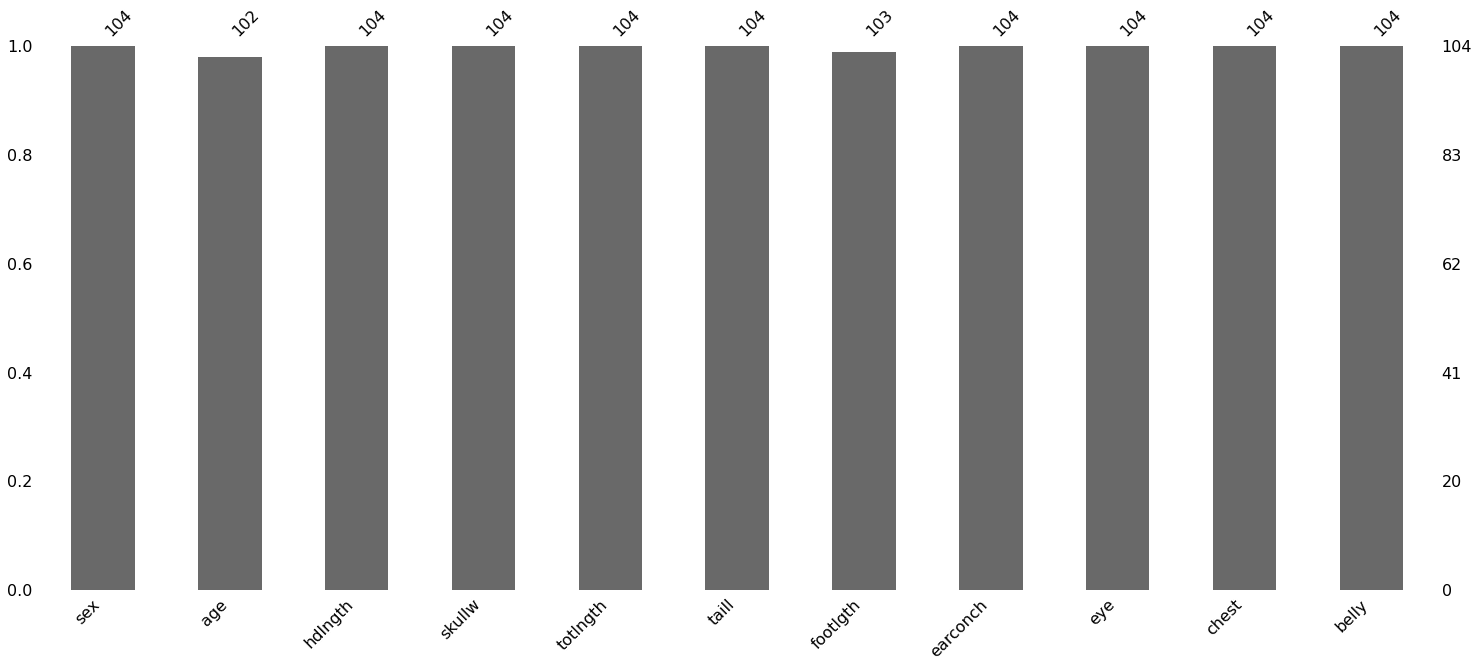

In [6]:
msno.bar(df)

In [7]:
df.dropna(inplace = True)

<AxesSubplot:>

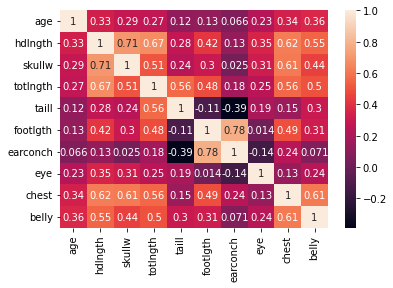

In [168]:
sns.heatmap(df.corr(), annot = True)

In [8]:
#sns.pairplot(df, hue="sex")

In [9]:
## Feature Engineering

dataset = pd.get_dummies(df, columns=['sex'], prefix='', prefix_sep='')

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,1:], dataset['age'], test_size=0.33, random_state=42)

## Baseline Model

In [162]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [164]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train_scaled, y_train)

In [165]:
reg.score(X_train_scaled, y_train)

0.20813118243845807

<AxesSubplot:xlabel='residuals', ylabel='predictions'>

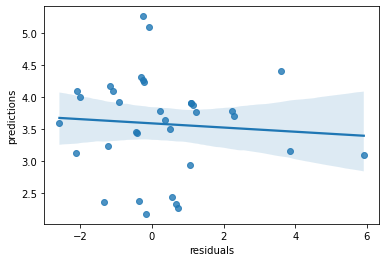

In [169]:
# Residual Analysis

predictions = reg.predict(X_test_scaled)
foo = np.concatenate((np.array(y_test - predictions).reshape(-1,1), predictions.reshape(-1,1)), axis = 1)
foo2 = pd.DataFrame(foo, columns = ['residuals','predictions'])
sns.regplot(foo2, x = 'residuals',y='predictions')

## Artificual Neural Network

In [12]:
# Prepare Normalizer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

2022-12-27 21:54:51.040931: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-27 21:54:51.040993: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-27 21:54:51.041030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-12-27 21:54:51.041581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [170]:
from tensorflow.keras import regularizers

# Create the Model
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.L1(0.01)),
    layers.Dropout(.2),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.L1(0.01)),
    layers.Dropout(.2),
    layers.Dense(units=1)
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense_25 (Dense)            (None, 8)                 96        
                                                                 
 dropout_13 (Dropout)        (None, 8)                 0         
                                                                 
 dense_26 (Dense)            (None, 8)                 72        
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                      

In [172]:
# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [171]:
from keras.callbacks import EarlyStopping

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [173]:
%%time
history = model.fit(
    X_train,
    y_train,
    epochs=25,
    verbose = 0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    callbacks = [es]
)

CPU times: user 1.92 s, sys: 89.9 ms, total: 2.01 s
Wall time: 2.92 s


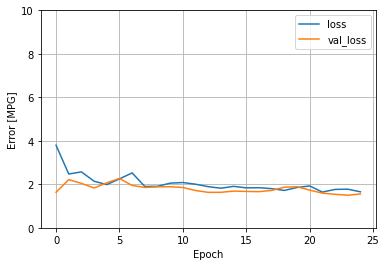

In [174]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [55]:
#model.predict(X_train[:10])

1/1 [==============================] - 0s 70ms/step


array([[3.3003867],
       [2.5274844],
       [3.9526896],
       [4.3210697],
       [5.3930073],
       [3.4444494],
       [3.063393 ],
       [6.250927 ],
       [5.4252763],
       [2.7718396]], dtype=float32)

MSE between train and test sets are comparable.

In [177]:
predictions = model.predict(X_test).reshape(-1,)

2/2 [==============================] - 0s 3ms/step


In [178]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_train, model.predict(X_train).reshape(-1,))

3/3 [==============================] - 0s 4ms/step


1.263322741238039

In [180]:
mean_absolute_error(y_test, predictions)

1.4411238922792322

In [181]:
#foo = np.concatenate((np.array(y_test - predictions).reshape(-1,1), predictions.reshape(-1,1)), axis = 1)
foo = np.concatenate((np.array(y_test - predictions).reshape(-1,1), predictions.reshape(-1,1)), axis = 1)

In [182]:
foo2 = pd.DataFrame(foo, columns = ['residuals','predictions'])

<AxesSubplot:xlabel='residuals', ylabel='predictions'>

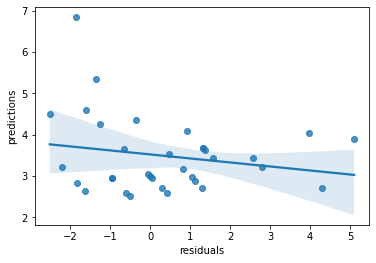

In [183]:
# https://stackoverflow.com/questions/62681388/residual-plot-for-residual-vs-predicted-value-in-python
sns.regplot(foo2, x = 'residuals',y='predictions')

In [184]:
# https://stackoverflow.com/questions/65699008/how-can-i-calculate-r-square-in-pandas-dataframe-elegantly

from sklearn.metrics import r2_score
r2_score(foo2['residuals'], foo2['predictions'])

-3.3550840040199974

Based on the correlation plot, we can rule out any modeling for age with the features given to us. The models produce poor results because these features have weak predictive power for age. 

Resources/References:
- https://www.tensorflow.org/tutorials/keras/regression
- https://www.kaggle.com/code/elisthefox/predicting-fuzzy-and-his-possum-friends